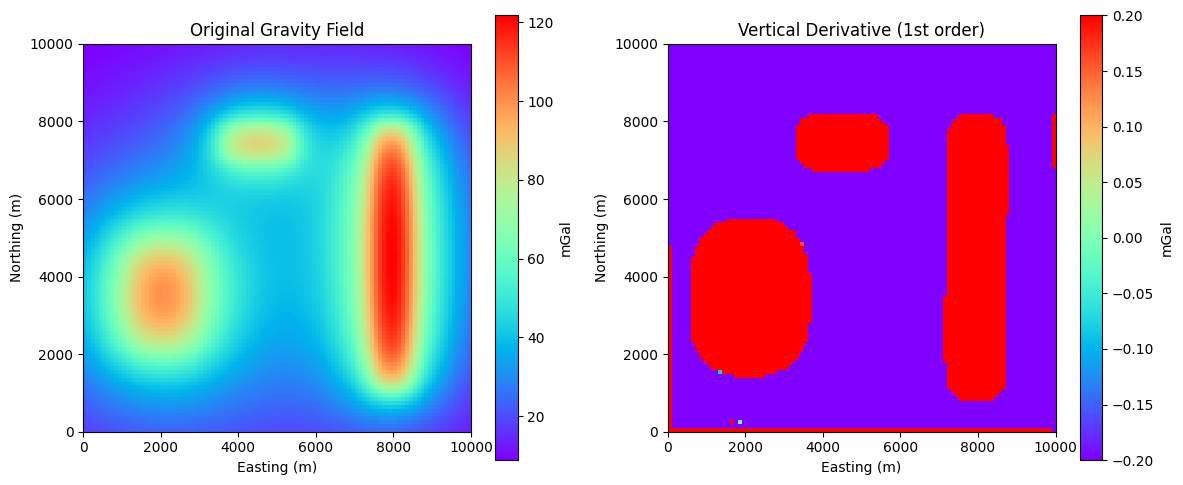

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import verde as vd
import harmonica as hm
from scipy.fftpack import fft2, ifft2, fftfreq

# Define the prism model [west, east, south, north, bottom, top]
prisms = [
    [1000, 3000, 2000, 5000, -10000, -500], #lightblue
    [3500, 5500, 7000, 8000, -2500, -200],  #light green
    [7500, 8500, 1000, 8000, -3000, -200],  # Red
]
densities = [2670, 3300, 4000]  # Densities of prisms


# Generate a grid of coordinates
coordinates = vd.grid_coordinates(region=(0, 10e3, 0, 10e3), shape=(100, 100), extra_coords=0)

# Compute gravity field due to prisms
g_z = hm.prism_gravity(coordinates, prisms, densities, field="g_z")

# Convert to xarray grid
grid = vd.make_xarray_grid(coordinates, g_z, data_names="g_z", extra_coords_names="extra")

# Extract gravity field as a 2D numpy array
gravity_data = grid.g_z.values
ny, nx = gravity_data.shape
dx = (10e3) / nx  # Grid spacing in x-direction
dy = (10e3) / ny  # Grid spacing in y-direction

# Perform 2D FFT
fft_gravity = fft2(gravity_data*100000)

# Compute frequency components
kx = fftfreq(nx, dx)
ky = fftfreq(ny, dy)
KX, KY = np.meshgrid(kx, ky)
K = np.sqrt(KX**2 + KY**2)  # Wavenumber magnitude

# Define upward continuation height (in meters)

n = 1
# Compute upward continuation filter
upward_filter = np.abs(K) ** n

# Apply the filter in the Fourier domain
fft_upward_continued = fft_gravity * upward_filter

# Perform inverse FFT to get back to spatial domain
gravity_upward = np.real(ifft2(fft_upward_continued))

# Convert back to xarray grid
grid_upward = vd.make_xarray_grid(coordinates, gravity_upward, data_names="g_z", extra_coords_names="extra")

# Create figure for plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot original gravity field
c1 = axes[0].imshow(gravity_data, extent=(0, 10e3, 0, 10e3), origin='lower', cmap='rainbow')
axes[0].set_title("Original Gravity Field")
axes[0].set_xlabel("Easting (m)")
axes[0].set_ylabel("Northing (m)")
fig.colorbar(c1, ax=axes[0], label="mGal")


# Plot upward continued gravity field
c2 = axes[1].imshow(gravity_upward, extent=(0, 10e3, 0, 10e3), origin='lower', cmap='rainbow',vmin = -0.2, vmax = 0.2)
axes[1].set_title(f"Vertical Derivative ({n}st order)")
axes[1].set_xlabel("Easting (m)")
axes[1].set_ylabel("Northing (m)")
fig.colorbar(c2, ax=axes[1], label="mGal")

# Show the plots
plt.tight_layout()
plt.show()

In [2]:
pip install harmonica


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.9/390.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.6/186.6 kB 17.2 MB/s eta 0:00:00


In [4]:
from google.colab import files
uploaded=files.upload()

Saving Tutorial_7_cudapah_utm_csv.csv to Tutorial_7_cudapah_utm_csv.csv


In [5]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
from scipy.fftpack import fft2, ifft2, fftfreq

# File path
gravity_data=pd.read_csv("Tutorial_7_cudapah_utm_csv.csv")
# Load data

z = gravity_data["BA"]

# Extract coordinate information
longitude = gravity_data['longitude']
latitude = gravity_data['latitude']
#lon_grid, lat_grid = np.meshgrid(lon, lat,0.1)  # Correct meshgrid order

lon_min, lon_max=longitude.min(),longitude.max()
lat_min, lat_max=latitude.min(),latitude.max()
resolution=100

lon_grid = np.linspace(lon_min, lon_max,resolution)
lat_grid =np.linspace(lat_min, lat_max,resolution)
lon_mesh,lat_mesh=np.meshgrid(lon_grid,lat_grid)
gravity_data

,longitude,latitude,BA
0,7.500000e+05,1450000.0,113.481410
1,7.538961e+05,1450000.0,108.950674
2,7.577922e+05,1450000.0,112.787263
3,7.616883e+05,1450000.0,112.255976
4,7.655844e+05,1450000.0,111.194501
...,...,...,...
7795,1.034416e+06,1950000.0,6.878421
7796,1.038312e+06,1950000.0,2.152631
7797,1.042208e+06,1950000.0,0.072575
7798,1.046104e+06,1950000.0,0.204881


In [6]:
zi = griddata((gravity_data['longitude'], gravity_data['latitude']),gravity_data['BA'], (lon_mesh, lat_mesh), method='cubic')


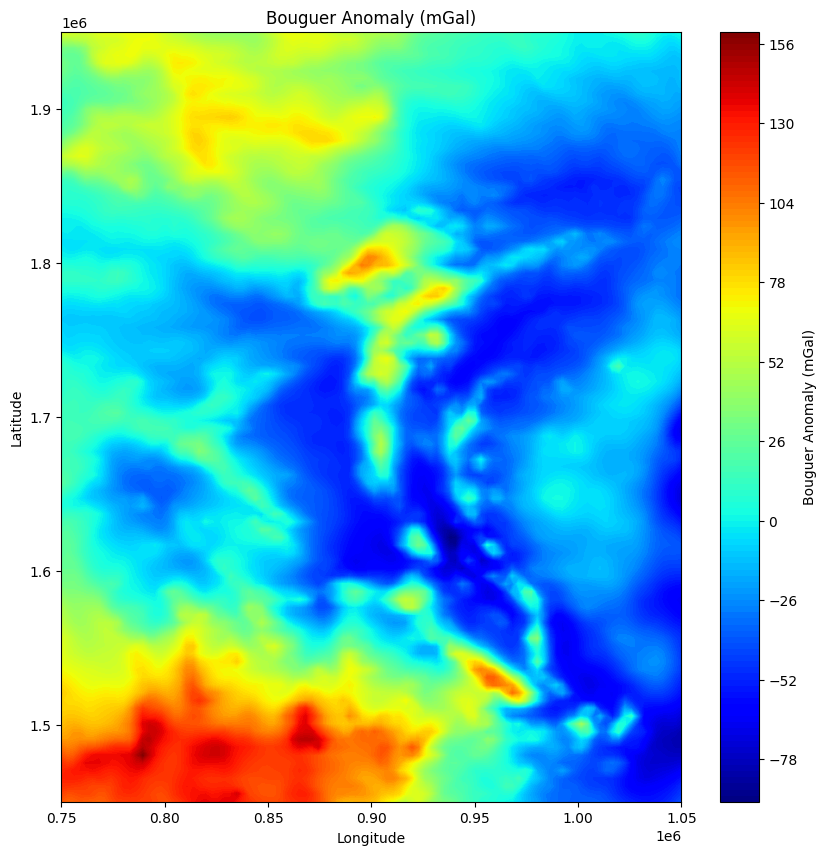

In [7]:
# Plot the grid data
fig, ax = plt.subplots(figsize=(10, 10))
#ax=plt.subplot(lon[3],lat[0])
# Filled contour plot
cp = ax.contourf(lon_grid, lat_grid, zi, cmap='jet', levels=150)  # Transpose z-values for correct orientation

cbar = plt.colorbar(cp, ax=ax, label='Bouguer Anomaly (mGal)')

# Labels and limits
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Bouguer Anomaly (mGal)')

# Show plot
plt.show()

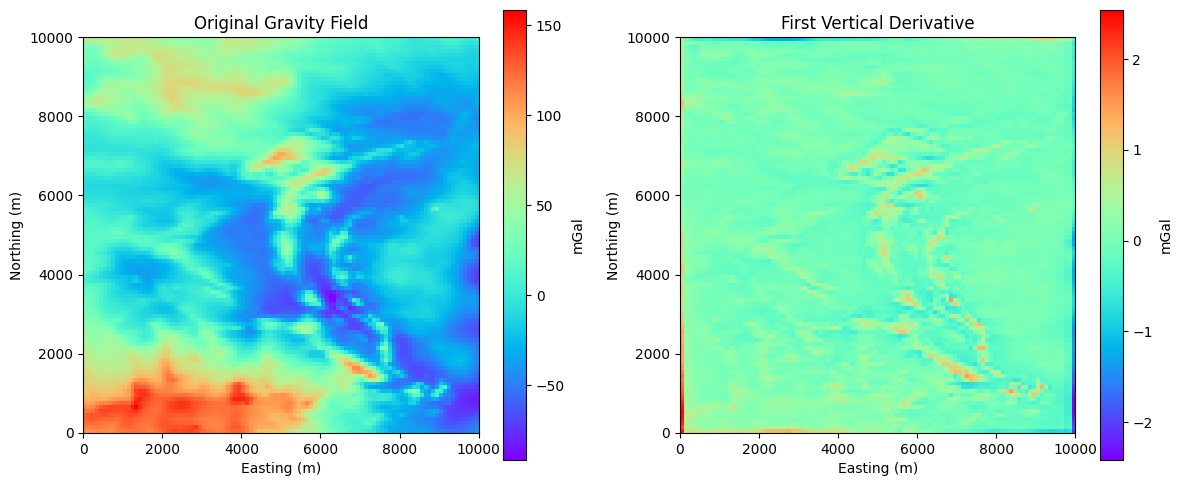

In [8]:
#coordinates = vd.grid_coordinates(region=(0, 10e3, 0, 10e3), shape=(1000, 1000), extra_coords=0)
ny, nx = zi.shape
dx = 10  # Grid spacing in x-direction
dy = 10  # Grid spacing in y-direction

fft_gravity = fft2(zi)

# Compute frequency components
kx = fftfreq(nx, dx)
ky = fftfreq(ny, dy)
KX, KY = np.meshgrid(kx, ky)
K = np.sqrt(KX**2 + KY**2)  # Wavenumber magnitude

# Define upward continuation height (in meters)

n = 1
# Compute upward continuation filter
FVD = np.abs(K) ** n

# Apply the filter in the Fourier domain
fft_FVD = fft_gravity * FVD

# Perform inverse FFT to get back to spatial domain
gravity_FVD = np.real(ifft2(fft_FVD))
#grid_FVD2 = vd.make_xarray_grid(coordinates, gravity_FVD, data_names="g_z", extra_coords_names="extra")

# Convert back to xarray grid
#grid_upward = vd.make_xarray_grid(coordinates, gravity_upward, data_names="g_z", extra_coords_names="extra")

# Create figure for plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot original gravity field
c1 = axes[0].imshow(zi, extent=(0, 10e3, 0, 10e3), origin='lower', cmap='rainbow')
axes[0].set_title("Original Gravity Field")
axes[0].set_xlabel("Easting (m)")
axes[0].set_ylabel("Northing (m)")
fig.colorbar(c1, ax=axes[0], label="mGal")

# Plot upward continued gravity field
c2 = axes[1].imshow(gravity_FVD, extent=(0, 10e3, 0, 10e3), origin='lower', cmap='rainbow')
axes[1].set_title(f"First Vertical Derivative")
axes[1].set_xlabel("Easting (m)")
axes[1].set_ylabel("Northing (m)")
fig.colorbar(c2, ax=axes[1], label="mGal")

# Show the plots
plt.tight_layout()
plt.show()

In [9]:
print(nx,ny)

100 100


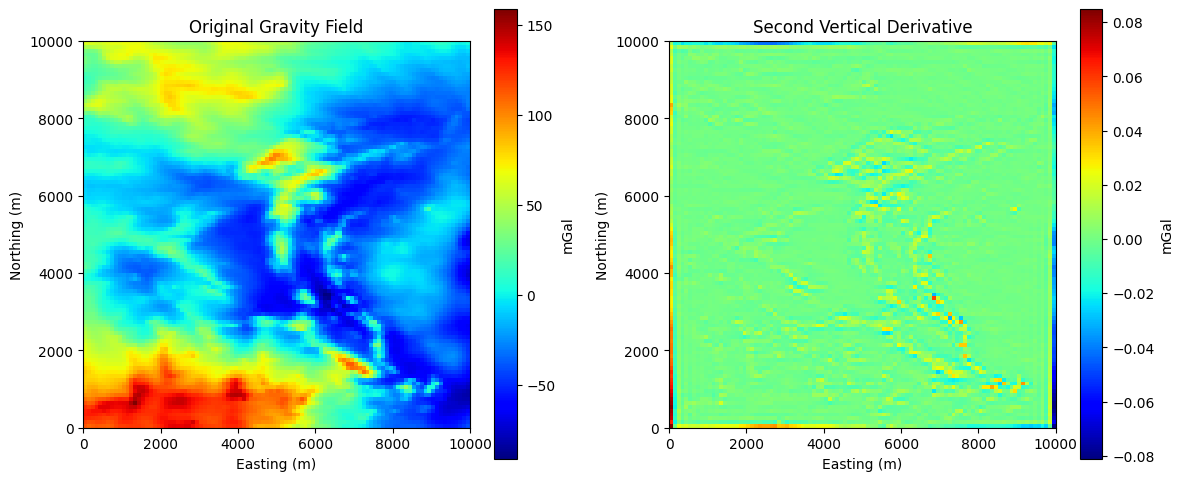

In [10]:
#coordinates = vd.grid_coordinates(region=(0, 10e3, 0, 10e3), shape=(3000, 3000), extra_coords=0)
ny, nx = zi.shape
dx = 10  # Grid spacing in x-direction
dy = 10

fft_gravity = fft2(zi)

# Compute frequency components
kx = fftfreq(nx, dx)
ky = fftfreq(ny, dy)
KX, KY = np.meshgrid(kx, ky)
K = np.sqrt(KX**2 + KY**2)  # Wavenumber magnitude

# Define upward continuation height (in meters)

n = 2
# Compute upward continuation filter
SVD = np.abs(K) ** n

# Apply the filter in the Fourier domain
fft_SVD = fft_gravity * SVD

# Perform inverse FFT to get back to spatial domain
gravity_SVD = np.real(ifft2(fft_SVD))
#grid_FVD2 = vd.make_xarray_grid(coordinates, gravity_SVD, data_names="g_z", extra_coords_names="extra")

# Convert back to xarray grid
#grid_upward = vd.make_xarray_grid(coordinates, gravity_upward, data_names="g_z", extra_coords_names="extra")

# Create figure for plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot original gravity field
c1 = axes[0].imshow(zi, extent=(0, 10e3, 0, 10e3), origin='lower', cmap='jet')
axes[0].set_title("Original Gravity Field")
axes[0].set_xlabel("Easting (m)")
axes[0].set_ylabel("Northing (m)")
fig.colorbar(c1, ax=axes[0], label="mGal")

# Plot upward continued gravity field
c2 = axes[1].imshow(gravity_SVD, extent=(0, 10e3, 0, 10e3), origin='lower', cmap='jet')
axes[1].set_title(f"Second Vertical Derivative")
axes[1].set_xlabel("Easting (m)")
axes[1].set_ylabel("Northing (m)")
fig.colorbar(c2, ax=axes[1], label="mGal")

# Show the plots
plt.tight_layout()
plt.show()

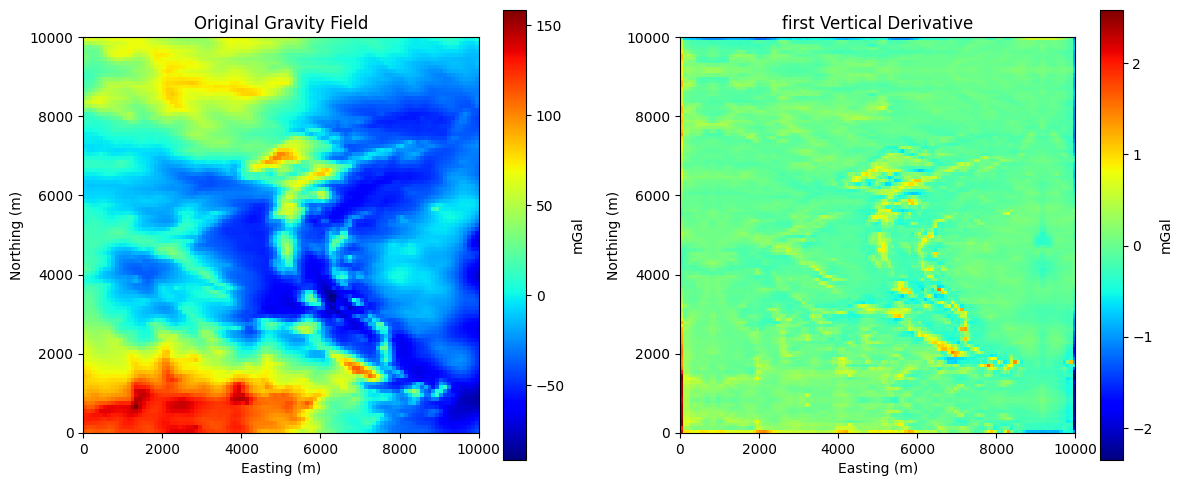

In [17]:
padsize=10
padded_zi=np.pad(zi,padsize, mode='symmetric')
ny, nx = padded_zi.shape
dx = 10  # Grid spacing in x-direction
dy = 10

fft_gravity = fft2(padded_zi)

# Compute frequency components
kx = fftfreq(nx, dx)
ky = fftfreq(ny, dy)
KX, KY = np.meshgrid(kx, ky)
K = np.sqrt(KX**2 + KY**2)  # Wavenumber magnitude

# Define upward continuation height (in meters)

n = 1
# Compute upward continuation filter
SVD = np.abs(K) ** n

# Apply the filter in the Fourier domain
fft_SVD = fft_gravity * SVD

# Perform inverse FFT to get back to spatial domain
gravity_SVD = np.real(ifft2(fft_SVD))
#grid_FVD2 = vd.make_xarray_grid(coordinates, gravity_SVD, data_names="g_z", extra_coords_names="extra")

# Convert back to xarray grid
#grid_upward = vd.make_xarray_grid(coordinates, gravity_upward, data_names="g_z", extra_coords_names="extra")

# Create figure for plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot original gravity field
c1 = axes[0].imshow(zi, extent=(0, 10e3, 0, 10e3), origin='lower', cmap='jet')
axes[0].set_title("Original Gravity Field")
axes[0].set_xlabel("Easting (m)")
axes[0].set_ylabel("Northing (m)")
fig.colorbar(c1, ax=axes[0], label="mGal")

# Plot upward continued gravity field
c2 = axes[1].imshow(gravity_SVD, extent=(0, 10e3, 0, 10e3), origin='lower', cmap='jet')
axes[1].set_title(f"first Vertical Derivative")
axes[1].set_xlabel("Easting (m)")
axes[1].set_ylabel("Northing (m)")
fig.colorbar(c2, ax=axes[1], label="mGal")

# Show the plots
plt.tight_layout()
plt.show()

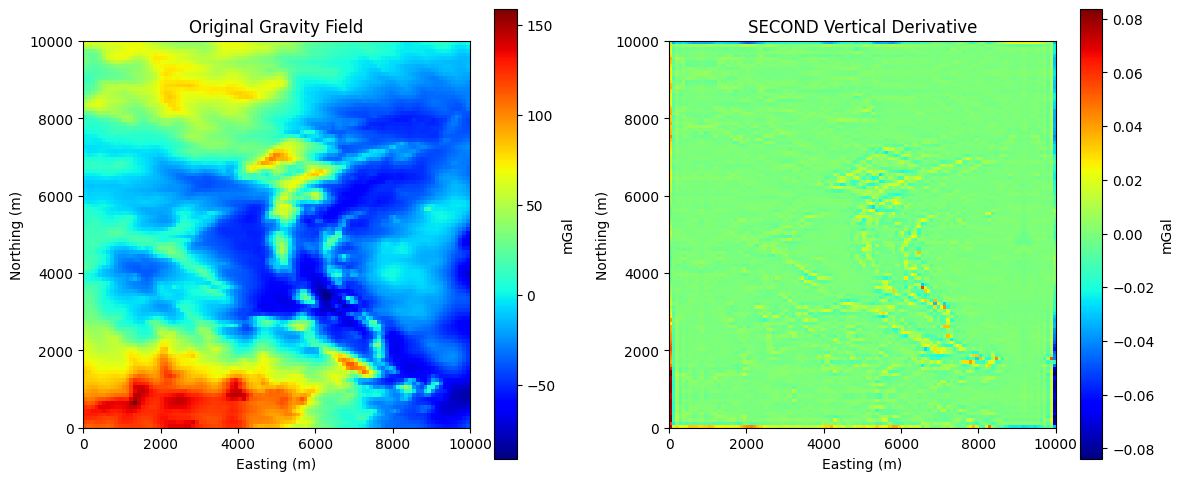

In [19]:
padsize=10
padded_zi=np.pad(zi,padsize, mode='symmetric')
ny, nx = padded_zi.shape
dx = 10  # Grid spacing in x-direction
dy = 10

fft_gravity = fft2(padded_zi)

# Compute frequency components
kx = fftfreq(nx, dx)
ky = fftfreq(ny, dy)
KX, KY = np.meshgrid(kx, ky)
K = np.sqrt(KX**2 + KY**2)  # Wavenumber magnitude

# Define upward continuation height (in meters)

n = 2
# Compute upward continuation filter
SVD = np.abs(K) ** n

# Apply the filter in the Fourier domain
fft_SVD = fft_gravity * SVD

# Perform inverse FFT to get back to spatial domain
gravity_SVD = np.real(ifft2(fft_SVD))
#grid_FVD2 = vd.make_xarray_grid(coordinates, gravity_SVD, data_names="g_z", extra_coords_names="extra")

# Convert back to xarray grid
#grid_upward = vd.make_xarray_grid(coordinates, gravity_upward, data_names="g_z", extra_coords_names="extra")

# Create figure for plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot original gravity field
c1 = axes[0].imshow(zi, extent=(0, 10e3, 0, 10e3), origin='lower', cmap='jet')
axes[0].set_title("Original Gravity Field")
axes[0].set_xlabel("Easting (m)")
axes[0].set_ylabel("Northing (m)")
fig.colorbar(c1, ax=axes[0], label="mGal")

# Plot upward continued gravity field
c2 = axes[1].imshow(gravity_SVD, extent=(0, 10e3, 0, 10e3), origin='lower', cmap='jet')
axes[1].set_title(f"SECOND Vertical Derivative")
axes[1].set_xlabel("Easting (m)")
axes[1].set_ylabel("Northing (m)")
fig.colorbar(c2, ax=axes[1], label="mGal")

# Show the plots
plt.tight_layout()
plt.show()